# Train an CNN from scratch using the CIFAR-10 dataset

This notebook present an (over-)simplified but working pipeline to

1. Build a CNN network.
2. Train the CNN network using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Then the trained model and other data will be saved for later usage. In this way, we can perform various downstream tasks, such as model compression.

In [1]:
import tensorflow as tf
import numpy as np
import os
import time

from collections import defaultdict
from tensorflow.keras import layers, models

In [2]:
# set random seeds
tf.random.set_seed(251211)
np.random.seed(251211)

## Hyperparameters

In [3]:
INIT_LR = 1e-3
N_EPOCH = 10
BATCH_SIZE = 64

## Data preparation

In [4]:
def load_and_preprocess_data():
    """Load and preprocess CIFAR-10 dataset."""
    print("Loading CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    print(f"Training samples: {len(x_train)}")
    print(f"Test samples: {len(x_test)}")
    print(f"Image shape: {x_train[0].shape}")

    return (x_train, y_train), (x_test, y_test)

We use the above function to download data and perform train/test split.

In [5]:
# Load data
train_data, test_data = load_and_preprocess_data()

Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3)


## Model design

In [6]:
def create_cnn_model():
    """Create a CNN model for CIFAR-10 classification."""

    # 32x32 RGB image input shape for CIFAR-10
    input_shape = (32, 32, 3)

    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    model = models.Sequential([
        tf.keras.Input(shape=input_shape),
        data_augmentation,

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

Have a look at the model.

In [7]:
model = create_cnn_model()
# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Model training

In [8]:
x_train, y_train = train_data
x_test, y_test = test_data

# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

print("\nStarting training...")
print(f"Epochs: {N_EPOCH}, Batch size: {BATCH_SIZE}")
print("-" * 50)

# Train with augmentation
history = model.fit(
    x_train, y_train,
    epochs=N_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Starting training...
Epochs: 10, Batch size: 64
--------------------------------------------------
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.3310 - loss: 2.1550 - val_accuracy: 0.4437 - val_loss: 1.8175 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5212 - loss: 1.3435 - val_accuracy: 0.5114 - val_loss: 1.6594 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5941 - loss: 1.1557 - val_accuracy: 0.6105 - val_loss: 1.1256 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.6331 - loss: 1.0525 - val_accuracy: 0.6259 - val_loss: 1.1797 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6639 - loss: 0.9664 - val_accuracy: 0.6691 - val_loss: 0.9836 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6793 - loss: 0.9188 - val_accuracy: 0.6963 - val_loss: 0.9500 

## Model evaluation

In [9]:
x_test, y_test = test_data
print("\nEvaluating model on test set...")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Evaluating model on test set...
Test Loss: 0.7136
Test Accuracy: 0.7576 (75.76%)


The accuracy is not very high, as the main idea of this notebook is simply providing a baseline to continue to compress models. If you are interested in optimizing the classification performance, the following tips may be helpful:

1. Find better model architecture, e.g., [ResNet](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), and [ConvNeXT](https://openaccess.thecvf.com/content/CVPR2022/papers/Liu_A_ConvNet_for_the_2020s_CVPR_2022_paper.pdf). You might heard of Vision Transformer ([ViT](openreview.net/forum?id=YicbFdNTTy)), but it usually requires a very large dataset to train it from stratch. This is also true for large variants of ConvNeXT. CIFAR-10 is too small to train such large models, inducing poor performances. You may observe very good results of those large models on CIFAR-10 (~95%), but they usually require transfer learning to inherit the knowledge trained from a large amount of data instead of training from scratch.

2. Better [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) will help.

3. Find a better set of hyperparameters by [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner).

Nevertheless, the main goal of this material is to get familiar with tensorflow and LiteRT optimization. Therefore, the performance is not the main focus. The important thing is to compress a model without significant performance drop. We will see how to do it later.

## Save models and data

In [10]:
# save model
model_path = 'cifar10_model.keras'
model.save(model_path)
print(f"\nModel saved to: {model_path}")

# also save in SavedModel format for TFLite conversion
saved_model_path = 'cifar10_saved_model'
model.export(saved_model_path)
print(f"SavedModel exported to: {saved_model_path}/")

# save test data for later comparison
np.savez('test_data.npz', x_test=test_data[0], y_test=test_data[1])
print("Test data saved to: test_data.npz")


Model saved to: cifar10_model.keras
Saved artifact at 'cifar10_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132144080910864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144080912016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132146621666256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144078034448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144078035216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144078035792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144078035984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144078033104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144078033488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144078035024: TensorSpec(shape=(), dtype=t

Now you can see models and data saved in the same folder.

In [11]:
!ls -lh

total 129M
-rw-r--r-- 1 root root 1.6M Dec  8 15:03 cifar10_model_float16.tflite
-rw-r--r-- 1 root root 9.5M Dec  8 15:42 cifar10_model.keras
drwxr-xr-x 4 root root 4.0K Dec  8 15:42 cifar10_saved_model
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 118M Dec  8 15:42 test_data.npz


# Model compression using TFLite

In [12]:
def load_model_and_data():
    """Load the trained model and test data."""
    print("Loading trained model...")

    # Load the Keras model
    model = tf.keras.models.load_model('cifar10_model.keras')
    print("Model loaded successfully!")

    # Load test data for representative dataset
    print("Loading test data for calibration...")
    data = np.load('test_data.npz')
    x_test = data['x_test']
    y_test = data['y_test']

    return model, x_test, y_test

Load the saved model and data.

In [13]:
model, x_test, y_test = load_model_and_data()
model.summary()

Loading trained model...
Model loaded successfully!
Loading test data for calibration...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 2,448,000 (9.34 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 1,631,062 (6.22 MB)

## `Float16` quantization

The following function is a practical example of model quantization, a technique used to prepare deep learning models for deployment on edge devices like smartphones or microcontrollers. We uses the `TFLiteConverter` to translate the standard Keras model into the specialized TensorFlow Lite (TFLite) format, which is optimized for mobile inference. We perform `float16` quantization, which halves the size of the model's weights and activations from 32-bit floating-point numbers to 16-bit, significantly reducing the file size and accelerating inference with minimal loss in accuracy.

In [14]:
def convert_to_tflite_float16(model, output_path='cifar10_model_float16.tflite'):
    """Convert model to TFLite with float16 quantization."""
    print("\n" + "-" * 50)
    print("Converting to TFLite (Float16 Quantization)...")

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]

    tflite_model = converter.convert()

    with open(output_path, 'wb') as f:
        f.write(tflite_model)

    size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"Saved: {output_path} ({size_mb:.2f} MB)")

    return output_path

In [15]:
convert_to_tflite_float16(model)


--------------------------------------------------
Converting to TFLite (Float16 Quantization)...
Saved artifact at '/tmp/tmpnz62k1dx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132144010891664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010888400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010890704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010890896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010889744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010890320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010891280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010891856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144010893584: TensorSpec(shape=(), dtype=tf.resource, 

'cifar10_model_float16.tflite'

model size comparison

In [16]:
def print_model_sizes():
    """Print size comparison of all models."""
    print("\n" + "=" * 60)
    print("MODEL SIZE COMPARISON")
    print("=" * 60)

    models = {
        'Original Keras (.keras)': 'cifar10_model.keras',
        'TFLite Float16': 'cifar10_model_float16.tflite',
    }

    original_size = None

    for name, path in models.items():
        if os.path.exists(path):
            size_bytes = os.path.getsize(path)
            size_mb = size_bytes / (1024 * 1024)

            if original_size is None:
                original_size = size_bytes
                compression = 1.0
            else:
                compression = original_size / size_bytes

            print(f"{name:20s}: {size_mb:8.2f} MB (compression: {compression:.2f}x)")

In [17]:
print_model_sizes()


MODEL SIZE COMPARISON
Original Keras (.keras):     9.45 MB (compression: 1.00x)
TFLite Float16      :     1.57 MB (compression: 6.04x)


# Performance comparison

Comparing model sizes is not comprehensive enough to assess the quality of model compression. We need to use test data to measure the inference accuracy. Meanwhile, to mimick real-world deployment cases, we feed one image at a time and compare the inference throughput to measure the effiency.

In [18]:
def load_test_data(num_samples=None):
    """Load test data."""
    print("Loading test data...")
    data = np.load('test_data.npz')
    x_test = data['x_test']
    y_test = data['y_test'].flatten()

    if num_samples is not None and num_samples < len(x_test):
        x_test = x_test[:num_samples]
        y_test = y_test[:num_samples]

    print(f"Loaded {len(x_test)} test samples")
    return x_test, y_test

def load_keras_model():
    """Load the original Keras model."""
    print("\nLoading Keras model...")
    model = tf.keras.models.load_model('cifar10_model.keras')
    return model

def load_tflite_model(model_path):
    """Load a TFLite model and return interpreter."""
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

def evaluate_keras_model(model, x_test, y_test, num_runs=3):
    """Evaluate Keras model performance and inference time (sample-by-sample)."""
    print("\n" + "-" * 60)
    print("Evaluating Keras Model")
    print("-" * 60)

    # Warm-up run (sample-by-sample)
    for i in range(min(10, len(x_test))):
        _ = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)

    all_predictions = []
    inference_times = []

    for run in range(num_runs):
        predictions_run = []
        start_time = time.perf_counter()

        for i in range(len(x_test)):
            # predict one sample at a time
            output = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)
            predictions_run.append(output[0])

        end_time = time.perf_counter()
        inference_times.append(end_time - start_time)

        if run == 0:
            all_predictions = np.array(predictions_run)

    # acc
    predicted_classes = np.argmax(all_predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_test)

    avg_time = np.mean(inference_times)
    std_time = np.std(inference_times)
    per_sample_time = avg_time / len(x_test) * 1000  # ms

    # model size
    model_path = 'cifar10_model.keras'
    model_size = os.path.getsize(model_path) / (1024 * 1024)

    results = {
        'accuracy': accuracy,
        'total_time': avg_time,
        'time_std': std_time,
        'per_sample_ms': per_sample_time,
        'model_size_mb': model_size,
        'predictions': all_predictions
    }

    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Total inference time: {avg_time:.3f}s \u00b1 {std_time:.3f}s")
    print(f"Per-sample time: {per_sample_time:.4f} ms")
    print(f"Model size: {model_size:.2f} MB")

    return results

def evaluate_tflite_model(model_path, x_test, y_test, num_runs=3):
    """Evaluate TFLite model performance and inference time."""
    model_name = os.path.basename(model_path)
    print(f"\n" + "-" * 60)
    print(f"Evaluating: {model_name}")
    print("-" * 60)

    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        return None

    # Load interpreter
    interpreter = load_tflite_model(model_path)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    input_dtype = input_details[0]['dtype']
    output_dtype = output_details[0]['dtype']

    print(f"Input shape: {input_shape}, dtype: {input_dtype}")
    print(f"Output dtype: {output_dtype}")

    # prepare input data based on model's expected dtype
    if input_dtype == np.uint8:
        # Quantized input - scale from [0,1] to [0,255]
        input_scale = input_details[0].get('quantization_parameters', {}).get('scales', [1.0])[0]
        input_zero_point = input_details[0].get('quantization_parameters', {}).get('zero_points', [0])[0]
        x_test_prepared = (x_test / input_scale + input_zero_point).astype(np.uint8)
    elif input_dtype == np.int8:
        input_scale = input_details[0].get('quantization_parameters', {}).get('scales', [1.0])[0]
        input_zero_point = input_details[0].get('quantization_parameters', {}).get('zero_points', [0])[0]
        x_test_prepared = (x_test / input_scale + input_zero_point).astype(np.int8)
    else:
        x_test_prepared = x_test.astype(np.float32)

    # warm-up
    for i in range(10):
        interpreter.set_tensor(input_details[0]['index'], x_test_prepared[i:i+1])
        interpreter.invoke()

    # run inference and collect predictions
    all_predictions = []
    inference_times = []

    for run in range(num_runs):
        predictions = []
        start_time = time.perf_counter()

        for i in range(len(x_test)):
            interpreter.set_tensor(input_details[0]['index'], x_test_prepared[i:i+1])
            interpreter.invoke()
            output = interpreter.get_tensor(output_details[0]['index'])
            predictions.append(output[0])

        end_time = time.perf_counter()
        inference_times.append(end_time - start_time)

        if run == 0:
            all_predictions = np.array(predictions)

    # Handle quantized output
    if output_dtype == np.uint8 or output_dtype == np.int8:
        output_scale = output_details[0].get('quantization_parameters', {}).get('scales', [1.0])[0]
        output_zero_point = output_details[0].get('quantization_parameters', {}).get('zero_points', [0])[0]
        all_predictions = (all_predictions.astype(np.float32) - output_zero_point) * output_scale

    predicted_classes = np.argmax(all_predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_test)

    avg_time = np.mean(inference_times)
    std_time = np.std(inference_times)
    per_sample_time = avg_time / len(x_test) * 1000  # ms

    model_size = os.path.getsize(model_path) / (1024 * 1024)

    results = {
        'accuracy': accuracy,
        'total_time': avg_time,
        'time_std': std_time,
        'per_sample_ms': per_sample_time,
        'model_size_mb': model_size,
        'predictions': all_predictions
    }

    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Total inference time: {avg_time:.3f}s \u00b1 {std_time:.3f}s")
    print(f"Per-sample time: {per_sample_time:.4f} ms")
    print(f"Model size: {model_size:.2f} MB")

    return results


def print_summary_table(all_results, keras_results):
    """Print a summary comparison table."""
    print("\n" + "=" * 100)
    print("SUMMARY COMPARISON TABLE")
    print("=" * 100)

    header = f"{'Model':<35} {'Accuracy':>10} {'Size (MB)':>12} {'Time (s)':>12} {'Speedup':>10} {'Compression':>12}"
    print(header)
    print("-" * 100)

    # Keras baseline
    print(f"{'Keras (baseline)':<35} {keras_results['accuracy']*100:>9.2f}% {keras_results['model_size_mb']:>11.2f} {keras_results['total_time']:>11.3f} {'1.00x':>10} {'1.00x':>12}")

    # TFLite models
    for name, results in all_results.items():
        if results is not None:
            speedup = keras_results['total_time'] / results['total_time']
            compression = keras_results['model_size_mb'] / results['model_size_mb']
            acc_diff = (results['accuracy'] - keras_results['accuracy']) * 100
            acc_str = f"{results['accuracy']*100:.2f}%"

            print(f"{name:<35} {acc_str:>10} {results['model_size_mb']:>11.2f} {results['total_time']:>11.3f} {speedup:>9.2f}x {compression:>11.2f}x")

    print("=" * 100)

Now, let's do a comprehensive comparison.

In [19]:
print("=" * 60)
print("Model Comparison: TensorFlow vs TFLite")
print("=" * 60)

# load 1000 test data samples for evaluation
x_test, y_test = load_test_data(num_samples=1000)

# Evaluate Keras model
k_model = load_keras_model()
k_results = evaluate_keras_model(k_model, x_test, y_test, num_runs=1)

# Define TFLite models to evaluate
tflite_models = {
    'TFLite Float16': 'cifar10_model_float16.tflite',
}

# Evaluate all TFLite models
all_results = {}
for name, path in tflite_models.items():
    results = evaluate_tflite_model(path, x_test, y_test, num_runs=1)
    if results is not None:
        all_results[name] = results

# Print summary table
print_summary_table(all_results, k_results)

Model Comparison: TensorFlow vs TFLite
Loading test data...
Loaded 1000 test samples

Loading Keras model...

------------------------------------------------------------
Evaluating Keras Model
------------------------------------------------------------
Accuracy: 76.30%
Total inference time: 63.703s ± 0.000s
Per-sample time: 63.7034 ms
Model size: 9.45 MB

------------------------------------------------------------
Evaluating: cifar10_model_float16.tflite
------------------------------------------------------------
Input shape: [ 1 32 32  3], dtype: <class 'numpy.float32'>
Output dtype: <class 'numpy.float32'>


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Accuracy: 76.30%
Total inference time: 1.544s ± 0.000s
Per-sample time: 1.5444 ms
Model size: 1.57 MB

SUMMARY COMPARISON TABLE
Model                                 Accuracy    Size (MB)     Time (s)    Speedup  Compression
----------------------------------------------------------------------------------------------------
Keras (baseline)                        76.30%        9.45      63.703      1.00x        1.00x
TFLite Float16                          76.30%        1.57       1.544     41.25x        6.04x


## Results

The following table is from the last execution of this notebook during its preparation. Your results are highly likely not exactly the same.

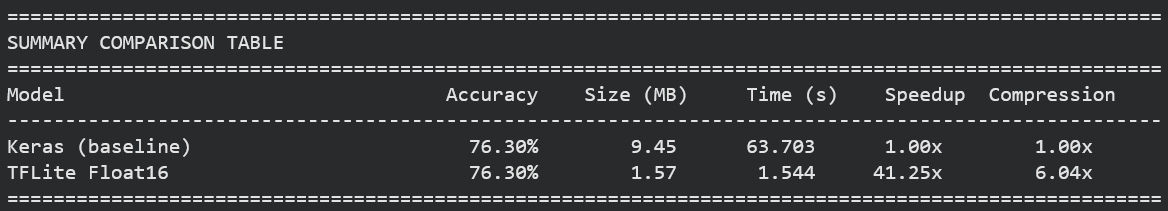

We can observe that `TFLite Float16` achieves 44.58x inference speed without accuracy downgradation. This represents the core motivation of our lab course.

# Materials for your exploration

This notebook gives you a first impression of model compression using half-precision quantization. You can find the complete document of TFLite (well, now it has a new name: LiteRT) [here](https://ai.google.dev/edge/litert).

Specifically, [this tutorial](https://ai.google.dev/edge/litert/libraries/modify/object_detection) is particularly helpful for you to train a custom object detection model.